In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from transformers import TFCamembertForSequenceClassification
import transformers.models.camembert.tokenization_camembert as tk

In [2]:
from tensorflow.python.client import device_lib

In [7]:
n_train = 8000
n_val = 1000
n_test = 1000

dataset_tweets = pd.read_csv("./data/french_tweets.csv").sample(n=(n_train+n_val+n_test))
# print(dataset_tweets.head())
tweets = dataset_tweets['text'].values.tolist()
sentiments = dataset_tweets['label'].values.tolist()

tweets_train = tweets[:n_train]
tweets_val = tweets[n_train:n_train+n_val]
tweets_test = tweets[n_train+n_val:]

labels_train = sentiments[:n_train]
labels_val = sentiments[n_train:n_train+n_val]
labels_test = sentiments[n_train+n_val:]

print(f'Nombre de tweets + : {sentiments.count(1)}  |   Nombre de tweet - : {sentiments.count(0)}')
print(f'Training: {len(tweets_train)}   |   Validation: {len(tweets_val)}    |   Test: {len(tweets_test)}')

Nombre de tweets + : 4909  |   Nombre de tweet - : 5091
Training: 8000   |   Validation: 1000    |   Test: 1000


In [4]:
dataset = pd.read_pickle("./data/allocine_dataset.pickle")

trunc = 0.05

train_reviews = np.array(dataset["train_set"]['review'])[:int(160000*trunc)]
val_reviews = np.array(dataset["val_set"]['review'])[:int(20000*trunc)]
test_reviews = np.array(dataset["test_set"]['review'])[:int(20000*trunc)]

train_labels = dataset["train_set"]['polarity'][:int(160000*trunc)]
val_labels = dataset["val_set"]['polarity'][:int(20000*trunc)]
test_labels = dataset["test_set"]['polarity'][:int(20000*trunc)]

class_names = dataset['class_names']

max_length = len(train_reviews)
print(f"train: {max_length}  val: {len(val_reviews)}  test: {len(test_reviews)}")

train: 8000  val: 1000  test: 1000


In [10]:
# model_name = "jplu/tf-camembert-base"
tokenizer = tk.CamembertTokenizer.from_pretrained("jplu/tf-camembert-base",do_lower_case=True)
assert tokenizer != None

In [11]:
def encode_reviews(tokenizer, reviews, max_length):
    token_ids = np.zeros(shape=(len(reviews), max_length),
                         dtype=np.int32)
    for i, review in enumerate(reviews):
        encoded = tokenizer.encode(review, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_mask = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_mask": attention_mask}

In [12]:
MAX_SEQ_LEN = 45
encoded_train = encode_reviews(tokenizer, tweets_train, MAX_SEQ_LEN)
encoded_valid = encode_reviews(tokenizer, tweets_val, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, tweets_test, MAX_SEQ_LEN)

y_train = np.array(labels_train)
y_val = np.array(labels_val)
y_test = np.array(labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [6]:
MAX_SEQ_LEN = 200
encoded_train = encode_reviews(tokenizer, train_reviews, MAX_SEQ_LEN)
encoded_valid = encode_reviews(tokenizer, val_reviews, MAX_SEQ_LEN)
encoded_test = encode_reviews(tokenizer, test_reviews, MAX_SEQ_LEN)
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
# model = TFCamembertForSequenceClassification.from_pretrained("camembert-base")
model = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")

opt = tf.keras.optimizers.Adam(learning_rate=3e-7, epsilon=1e-08)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at jplu/tf-camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
epochs = 20
batch_size = 4

history = model.fit(
    encoded_train, y_train,
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(encoded_valid, y_val), 
    verbose=1, 
    shuffle=True
)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2000/2000 [==============================] - 382s 180ms/step - loss: 0.6930 - accuracy: 0.5081 - val_loss: 0.6909 - val_accuracy: 0.5520
Epoch 2/20
2000/2000 [==============================] - 358s 179ms/step - loss: 0.6892 - accuracy: 0.5492 - va

In [15]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()


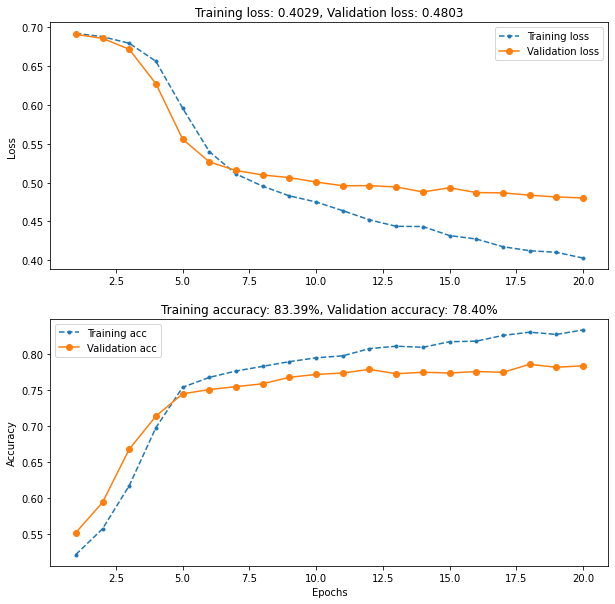

In [16]:
plot_loss_acc(history)

In [17]:
def prediction(x, mdl=model):
    scores = mdl.predict(x)
    y_pred = np.argmax(scores['logits'], axis=1)
    return y_pred
        

In [18]:
def evaluation(y,y_pred,graph=True):
    TP = np.count_nonzero(y*y_pred)
    TN = np.count_nonzero((y-1)*(y_pred-1))
    FN = np.count_nonzero((y-1)*y_pred)
    FP = np.count_nonzero(y*(y_pred-1))
    tot = TP+TN+FN+FP

    accuracy = metrics.accuracy_score(y, y_pred)
    f1_score = metrics.f1_score(y, y_pred)
    conf_mx = metrics.confusion_matrix(y, y_pred)

    conf_matrix = [[TN,FN],[FP,TP]]
    if((TP+FP) != 0 and (TP+FN) != 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
    else:
        precision = accuracy
        recall = -1
        f1 = f1_score

    # print(f"Precision: {round(100 * precision,2)}  /  {round(100 * accuracy,2)}")
    # print(f"F-score: {round(100 * f1,2)}  /  {round(100 * f1_score,2)}")
    # print(f"Rappel: {round(100 * recall,2)}")
    # print(f"Matrice: {conf_matrix}  /  {conf_mx}")

    print(f"Precision: {round(100 * precision,2)}")
    print(f"Rappel: {round(100 * recall,2)}")
    print(f"F-score: {round(100 * f1,2)}")
    print(f"%bon: {round(100*(TP+TN)/tot,2)} - %faux: {round(100*(FP+FN)/tot,2)}")
    print(f"Matrice: {conf_matrix}")
    if(graph):
        sns.heatmap(conf_matrix)
    return [precision,recall,f1_score,conf_matrix]

Precision: 81.2
Rappel: 77.19
F-score: 79.14
%bon: 78.6 - %faux: 21.4
Matrice: [[380, 120], [94, 406]]


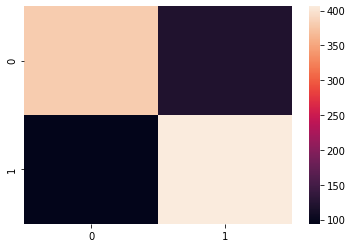

In [19]:
y_pred = prediction(encoded_test)
[precision,recall,f1_score,conf_matrix] = evaluation(y_test,y_pred)

In [20]:
model_name = f"./models_weights/f1{round(100*f1_score)}_count{len(tweets_train)}_epo{epochs}_batch{batch_size}.h5"
model.save_weights(model_name)

In [21]:
data_messages = pd.read_csv("./messages/messages0.csv")
msg_labels = data_messages['sentiments'].values.tolist()
msg = data_messages['messages'].values.tolist()

encoded_msg = encode_reviews(tokenizer, msg, 200)
y_msg = np.array(msg_labels)

Precision: 84.02
Rappel: 75.13
F-score: 79.33
%bon: 73.38 - %faux: 26.62
Matrice: [[62, 47], [27, 142]]


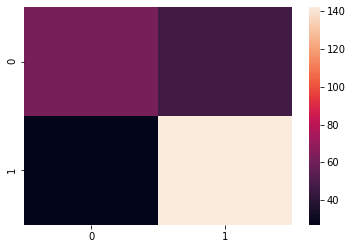

In [22]:
y_pred = prediction(encoded_msg)
_ = evaluation(y_msg,y_pred)

In [23]:
model1 = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")
models_weights = ["f145_count2500_epo15_batch24.h5", "f153_count1000_epo15_batch16.h5","f169_count8000_epo5_batch4.h5","f171_count5000_epo8_batch24.h5","f172_count500_epo8_batch24.h5","f176_count3680_epo10_batch14.h5","f177_count3680_epo3_batch12.h5","f179_count1000_epo8_batch24.h5","f179_count1440_epo20_batch24.h5","f179_count8000_epo7_batch4.h5","f179_count8000_epo18_batch4.h5","f180_count36800_epo10_batch16.h5","f181_count720_epo20_batch4.h5","f182_count720_epo20_batch24.h5","f184_count522_epo10_batch16.h5","f184_count720_epo20_batch16.h5","f191_count8000_epo3_batch4_allo.h5","f193_count8000_epo7_batch4_allo.h5","f194_count8000_epo10_batch4_allo.h5","f199_count522_epo10_batch16.h5"]
models_score = []

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

Some layers of TFCamembertForSequenceClassification were not initialized from the model checkpoint at jplu/tf-camembert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
best = [0,0,0,0]
best_name = ""
for w in models_weights:
    model1.load_weights(f"./models_weights/{w}")
    print(f'\n--- {w}')
    y_pred = prediction(encoded_msg, model1)
    score = evaluation(y_msg,y_pred,graph=False)
    if(score[2] > best[2]):
        best = score
        best_name = w
    models_score.append(score)



--- f145_count2500_epo15_batch24.h5
Precision: 81.07
Rappel: 75.69
F-score: 78.29
%bon: 72.66 - %faux: 27.34
Matrice: [[65, 44], [32, 137]]

--- f153_count1000_epo15_batch16.h5


KeyboardInterrupt: 

In [28]:
print(best_name)
print(best)
# f179_count8000_epo18_batch4.h5
# [0.8373493975903614, 0.7473118279569892, 0.7897727272727273, [[61, 47], [27, 139]]]

f179_count8000_epo18_batch4.h5
[0.8373493975903614, 0.7473118279569892, 0.7897727272727273, [[61, 47], [27, 139]]]
